# Project Phase II :  Citibike Data Analysis 


This project aims to answer the question 
 **"How inclusive / representitive is Citi Bike of New York City Demographics?"** in answering this question we look at three datasets. This notebook contains the initial **Data Collecting & Cleaning & Exploratory Analysis**

#### Team Members 
- Seonghee Lee (sl994) 
- Nicholas Rahardja (nmr73)
- Chelsea Choi (cc2583)

#### Team Github
- https://github.com/shljessie/citibike-nyc

#### Team Raw Data Google Drive 
- https://drive.google.com/drive/folders/197_d1BwPHXmVuyKA6I7UEyEw4Nqo8dAk

 
 
<br/> 

_______________


## Contents of this Notebook

1. Research Questions
2. Data Collecting & Cleaning
3. Data Description
4. Data Limitations
5. Data Exploratory Analysis
6. Questions for Reviewers



<br/>

_______________

# Research Question 



#### How inclusive / representative is Citi Bike of New York City Demographics? 

    - How inclusive are Citbike stations in NYC? 
    - How well does citbike station locations correspond with usage? 
    - Who does Citibike actually serve?
    
**Limitations/Disclaimer:** 
This project was done on NYC citibike trip data in 2017 

    
#### Explanation    

Bike Sharing comes with many benefits such as providing free or affordable access to bicycles for short-distance trips in an urban area and reducing congestion, noise, and air pollution. 

However whether or not these bike sharing systems are truly accessible for all is questionable. Since the accessibility of these bike sharing systems depend heavily on where the stations are located, it is very likely that where you live becomes the deciding factor in whether or not you will be able to use these bikes. 

In coming up with our research question looked at many research papers on bike sharing system equity. 
For example, in a [research done by Portland State University](https://trec.pdx.edu/research/project/884) suggests that there is evidence that significant portions of the population are underrepresented among bike share users, including people of color, along with lower-income, female, older adults and less-educated groups. A [article in 2017](https://usa.streetsblog.org/2017/07/05/whats-keeping-people-from-using-bike-share-new-study-breaks-it-down-by-race-and-income/) finds that this may be due to the fact that these low-income communities and people of color view traffic risk, high prices, and the potential for crime and harassment are the biggest barriers to bicycling and using bike-share in their neighborhoods. There has also been [data visualization research in MIT](https://aberke.github.io/income-race-bikes/) about how bikes are being distributed in NYC throughout the years in accordance to race&income.

In this project we look into how citibike stations are distributed in NYC and how that relates to factors: 1) race&income and  2) citibike usage. Is there more stations in areas of higher usage regardless of race and income? Or does race and income seem to have an unignorable correlation to how citibike stations are being distributed? How much of these factors play into the distribution of citibike? How might citibike station distribution be improved? These are the questions we will ask and attempt to answer throughout this project.
 
We are specificially looking at **NYC citibike trip data in 2017 as a sample** of the representation of NYC bike stations around New York. We chose New York City's citibike system since New York City is an area where there are widely varying levels of income. We chose 2017 for two reasons,    1) NYC's race and income data was avaiable for the years 2013 -2018 and 2) 2017 was a year when many new stations of citibike where added to represent its overall usage.
We decided that 2017 would be a fair representation of how citibike stations were distributed throughout NYC.


<br/>

_______________

# Data Collection and Cleaning 

## Citibike Trip Data

We collected our 2017 citibike trip data from https://s3.amazonaws.com/tripdata/index.html . 
Our Citibike Trip data cleaning consisted of 2 steps.

#### Part 1.  Cleaning Raw Trip data by Month

- We divided the 12 months into 3 and analyzed 4months each. In this step, we added the geoid to the citibike month data.
- How we divided the months: [Jan - April], [May- August], [Sep- December]
- We also dropped the columns : 
[ 'start station latitude','start station longitude','end station latitude', 'end station longitude', 'bikeid'] 

#### Part 2.  Combining the Months Together

- In this step we combined all the trip data together and cleaned up the data as below


1. Filtering mistakes we made in the Part 1 Process (Cleaning Raw Trip data by Month)

2. Combinined all the Months together

3. Coverting starttime+ stoptime to datetime objects 

4. User Filtering to Include only Subscribers

5. Dropping rows where start and end stations are the same 

6. Dropping rows where trip durations exceed 3 hours

7. Checking Missing values in columns



### Part 1 - Cleaning Raw Trip data by Month

Since the code we used to clean the data is mostly the same, 
**we will display the june cleaning as a representive for the initial process of the cleaning data.**

In [1]:
import pandas as pd 
import numpy as np
import requests
import urllib
import matplotlib.pyplot as plt 
import datetime as dt

### June

In [12]:
#June
june_raw = pd.read_csv('./201706-citibike-tripdata.csv')

In [41]:
june_raw.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

#### Read Stations csv file

In [42]:
st_geo_id = pd.read_csv('../citbike stations/citibike_stations_geoid.csv')
st_geo_id.head()

,Unnamed: 0,id,name,lat,lon,first,last,rides,geoid
0,0,254.0,W 11 St & 6 Ave,40.735324,-73.998004,2013-06-01,2019-07-31,168076,36061006300
1,1,151.0,Cleveland Pl & Spring St,40.721816,-73.997203,2013-06-01,2019-07-31,445639,36061004100
2,2,352.0,W 56 St & 6 Ave,40.763406,-73.977225,2013-06-01,2016-12-31,122203,36061010400
3,3,490.0,8 Ave & W 33 St,40.751551,-73.993934,2013-06-01,2019-07-31,480463,36061010300
4,4,236.0,St Marks Pl & 2 Ave,40.728419,-73.987140,2013-06-01,2019-07-31,292217,36061003800


We are calling in the station_geo_id data to join the geo id from the station data to raw may data

In [43]:
# Matching the geoids to the start station ID 
new_data = june_raw.join(st_geo_id.set_index(['id']), on=['start station id'], how='left').copy()

# Changing the column to start station geo ID
new_data.rename(columns = {'geoid': 'start_station_geoid'}, inplace = True)

# Dropping the columns carried over from station ID
new_data = new_data.drop(['Unnamed: 0', 'name', 'lat', 'lon', 'first', 'last', 'rides'], axis = 1).copy()

# Matching the geoids to the end station ID
new_data = new_data.join(st_geo_id.set_index(['id']), on=['end station id'], how='left').copy()
new_data = new_data.drop(['Unnamed: 0', 'name', 'lat', 'lon', 'first', 'last', 'rides'], axis = 1).copy()
new_data.rename(columns = {'geoid': 'end_station_geoid'}, inplace = True)

# Making all columns lower case
new_data.columns = map(str.lower, new_data.columns)

# Dropping columns we're not going to use
new_data = new_data.drop(['start station latitude','start station longitude','end station latitude', 'end station longitude', 'bikeid'], axis = 1).copy()
new_data.shape

(1523268, 12)

In [45]:
june_final = new_data
june_final.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'end station id', 'end station name', 'usertype',
       'birth year', 'gender', 'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [51]:
june_final.head()

,tripduration,starttime,stoptime,start station id,start station name,end station id,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid
0,1397,2017-06-01 00:00:02,2017-06-01 00:23:19,515,W 43 St & 10 Ave,3285,W 87 St & Amsterdam Ave,Subscriber,1967.0,1,3.606101e+10,3.606102e+10
1,1103,2017-06-01 00:00:13,2017-06-01 00:18:37,488,W 39 St & 9 Ave,297,E 15 St & 3 Ave,Subscriber,1981.0,1,3.606101e+10,3.606100e+10
2,1810,2017-06-01 00:00:20,2017-06-01 00:30:31,461,E 20 St & 2 Ave,465,Broadway & W 41 St,Subscriber,1982.0,1,3.606101e+10,3.606101e+10
3,1760,2017-06-01 00:00:24,2017-06-01 00:29:45,2009,Catherine St & Monroe St,527,E 33 St & 2 Ave,Subscriber,1973.0,2,3.606100e+10,3.606101e+10
4,2165,2017-06-01 00:00:33,2017-06-01 00:36:38,360,William St & Pine St,474,5 Ave & E 29 St,Subscriber,1985.0,1,3.606100e+10,3.606101e+10


#### Save to csv

In [46]:
june_final = june_final.to_csv('./june_final.csv')

**For this step we repeated this process for all the 12 months.**

### Part 2. Combining the citibike data by month


In this step, we called in all the citibike data by month and combined the 12 months together

In [71]:
# call in all the citibike data by month
jan_raw = pd.read_csv('./final/jan_final.csv')
feb_raw = pd.read_csv('./final/feb_final.csv')
march_raw = pd.read_csv('./final/march_final.csv')
april_raw = pd.read_csv('./final/april_final.csv')
may_raw = pd.read_csv('./final/may_final.csv')
june_raw = pd.read_csv('./final/june_final.csv')
july_raw = pd.read_csv('./final/july_final.csv')
august_raw = pd.read_csv('./final/august_final.csv')
sep_raw = pd.read_csv('./final/sep.csv')
oct_raw = pd.read_csv('./final/oct.csv')
nov_raw = pd.read_csv('./final/nov.csv')
dec_raw = pd.read_csv('./final/dec.csv')

<br/>

#### 1. Filtering mistakes we made in the Part 1 Process (Cleaning Raw Trip data by Month)

##### Checking we did the separate data cleaning process identically

In [81]:
#looking at the columns for jan-april group jan representative
jan_raw.columns

Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start station id', 'start station name', 'end station id',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [82]:
#looking at the columns for may-august group may representative
may_raw.columns

Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start station id', 'start station name', 'end station id',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [83]:
#looking at the columns for sep-dec group December representative
dec_raw.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station name',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')



<br/>

**Different Column Names Found**

For Jan - April the columns are named ['start time' 'stop time' 'trip duration''user type'] while for May-Dec the columns are named ['starttime' 'stoptime''tripduration''usertype'].
I will clean the Jan-April data so that the columns are ['starttime' 'stoptime' 'tripduration'' usertype'].  
(Without the space in between)

In [84]:
# renaming the columns for jan-april months
jan_raw = jan_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

In [85]:
feb_raw = feb_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

In [86]:
march_raw = march_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

In [87]:
april_raw = april_raw.rename(columns={'start time': 'starttime', 'stop time': 'stoptime', 'trip duration': 'tripduration','user type': 'usertype'})

<br/>

#### 2. Combine all the months together

In this step we will combine all of the citibike trip data together. 
We cleaned and added geoid data of 4months each. 

In [88]:
# concatenating the list of dataframes together
frames = [jan_raw,feb_raw, march_raw, april_raw, may_raw, june_raw ,july_raw,august_raw ,sep_raw ,oct_raw,nov_raw,dec_raw]
result = pd.concat(frames,ignore_index=True)

In [89]:
result.columns

Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start station id', 'start station name', 'end station id',
       'end station name', 'usertype', 'birth year', 'gender',
       'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [93]:
# printing out random rows in the result data
#sep-dec months
result.loc[10790070]

Unnamed: 0                                     NaN
tripduration                                   881
starttime                      2017-09-29 07:56:25
stoptime                       2017-09-29 08:11:06
start station id                               NaN
start station name           Pershing Square South
end station id                                 NaN
end station name       Greenwich St & W Houston St
usertype                                Subscriber
birth year                                    1966
gender                                           1
start_station_geoid                     3.6061e+10
end_station_geoid                       3.6061e+10
Name: 10790070, dtype: object

In [91]:
#may-august months
result.loc[8790090]

Unnamed: 0                            238237
tripduration                            1004
starttime                2017-08-04 19:59:25
stoptime                 2017-08-04 20:16:09
start station id                         284
start station name     Greenwich Ave & 8 Ave
end station id                           426
end station name       West St & Chambers St
usertype                            Customer
birth year                               NaN
gender                                     0
start_station_geoid               3.6061e+10
end_station_geoid                 3.6061e+10
Name: 8790090, dtype: object

In [92]:
#jan-april months
result.loc[100091]

Unnamed: 0                          100091
tripduration                           737
starttime              2017-01-05 21:06:47
stoptime               2017-01-05 21:19:04
start station id                       280
start station name         E 10 St & 5 Ave
end station id                         394
end station name         E 9 St & Avenue C
usertype                        Subscriber
birth year                            1961
gender                                   2
start_station_geoid             3.6061e+10
end_station_geoid               3.6061e+10
Name: 100091, dtype: object


<br/>

**Additional Start/End Stations Removed for Sep-Dec**

Because we did the data cleaning separately, we made a mistake in removing the start, end station ids . 

For months in September- December we don't have the the start and end station ids.

Fortunately we won't be using them for this project. So we will drop these columns

Checking out random rows like this makes sense because we divided the months by 4 months each and checking one month within the ranges would be representative of how that person did the data cleaning for the respective 4 months

#### Drop start,end station ids

Dropping the start,end station id errors we made in the previous process

In [97]:
result = result.drop(['start station id','end station id'], axis = 1).copy()

#### Save to csv
Saving the csv file and uploading to google drive so we can use for later

In [99]:
final_trip_data = result.to_csv('./final_trip_data.csv')

#### Additional Data Cleaning

After starting the data exploration we realized we needed to comeback and do addtional data cleaning.
We will be using this final cleaned data in our exploration process


In [2]:
df = pd.read_csv('../../data_exploration/final_trip_data.csv')

In [3]:
df.dtypes

Unnamed: 0               int64
Unnamed: 0.1           float64
tripduration             int64
starttime               object
stoptime                object
start station name      object
end station name        object
usertype                object
birth year             float64
gender                   int64
start_station_geoid    float64
end_station_geoid      float64
dtype: object

<br/>

#### 3. Convert to datetime objects

We will be converting the starttime and stoptime columns to datetime objects

In [3]:
df['starttime']=pd.to_datetime(df['starttime'], format='%Y-%m-%d %H:%M:%S')

In [4]:
df['stoptime']=pd.to_datetime(df['stoptime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
df.dtypes

Unnamed: 0                      int64
Unnamed: 0.1                  float64
tripduration                    int64
starttime              datetime64[ns]
stoptime               datetime64[ns]
start station name             object
end station name               object
usertype                       object
birth year                    float64
gender                          int64
start_station_geoid           float64
end_station_geoid             float64
dtype: object

<br/>

#### 4. User Filtering

Though many Citi Bike customers that are (1-day pass or 3-day pass) are often tourists and may not put in their birth year in a rush or due to other reasons. Also there are some Nan values for usertypes so we will be dropping those too

In [6]:
df['usertype'].unique()

array(['Subscriber', 'Customer', nan], dtype=object)

In [7]:
#getting dataframe usertypes for Subscribers only
df= df.loc[df['usertype']=='Subscriber']

In [8]:
df['usertype'].unique()

array(['Subscriber'], dtype=object)

In [9]:
df.shape

(14578993, 12)

<br/>

#### 5. Drop rows where start station and end stations are the same

Citi Bike riders often come across broken bikes. We will drop any trips where the start station = end station. This is an arbitrary choice based on how long it would take a rider to realize a bike isn’t working properly and coming back to the station to return it and take a new on. 

When the start station = end station we assumed that there would probably we a majority of cases where people where having trouble with using citibike in the inital process.

In [10]:
df= df.loc[df['start station name']!= df['end station name']]

In [11]:
df.shape

(14367769, 12)

In [12]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'tripduration', 'starttime', 'stoptime',
       'start station name', 'end station name', 'usertype', 'birth year',
       'gender', 'start_station_geoid', 'end_station_geoid'],
      dtype='object')

In [13]:
#drop columns that were added in this process by default
df=df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,tripduration,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10
8,255,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10


<br/>

#### 6. Check max Trip Duration

In [14]:
max=df['tripduration'].max()
max

9735948

In [15]:
dfd= df.loc[df['tripduration']==9735948]
dfd

,tripduration,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid
2313658,9735948,2017-04-03 07:50:27,2017-07-25 00:16:16,Fulton St & Rockwell Pl,NYCBS Depot - GOW,Subscriber,1983.0,1,3.604700e+10,3.604701e+10


The tripduration is in seconds so the max trip lasted 9735948/60 which is 162265.8 minutes which is 2704 hours, an unreasonable amount of time. This kind of data could result from a lost bike or a stolen one that was not reported. In 2017 for subscribers, 45minutes of unlimited citibike use was allowed. Sp we decided to include citibike data that was only used for under 3 hours. For additional hours of citibike usage, citibike charged its users $0.18 dollars for each additional minute.

**If you keep a bike out for longer than 30 minutes at a time, regardless of the type, it's $0.18 per minute.**
--According to citibike website in 2017 (https://www.citibikenyc.com/pricing/single-ride)

Therefore using a citibike for unreasonably long hours of time even if you are a subscriber would be unreasonable since you are being charged. 
For this analysis we decided to set 3hours as the limit to a reasonable amount of time a person uses a citibike. 

In [16]:
## drop trip durations over 3hours
df= df.loc[df['tripduration']<10800]
max=df['tripduration'].max()
max

10798

In [17]:
df.shape

(14356739, 10)

**Deleting Trip Duration Column and adding Trip Minutes Column**

For data analysis, we concluded that looking at trip durations in minutes instead of seconds was a better way to understand the data and easier to explain. We create a column in the data frame called trip minutes. We will delete the trip duration

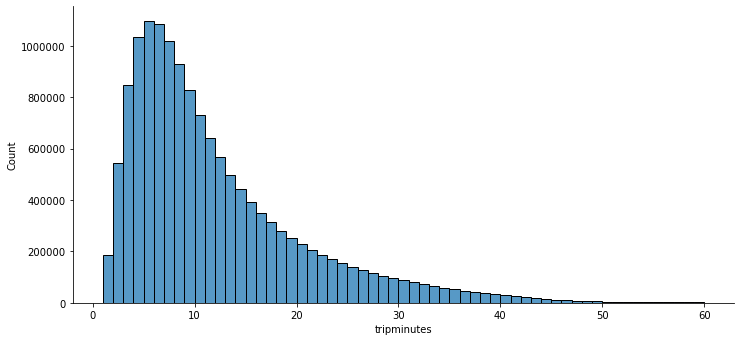

In [18]:
#create a plot to understand the trip duration
df['tripminutes'] = df['tripduration'] // 60
sns.displot(data=df,x="tripminutes", bins=range(1,61), aspect=10/5);
plt.ticklabel_format(style='plain', axis='y')

In [19]:
#drop trip duration column
df=df.drop(columns=['tripduration'])

In [20]:
df.head()

,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21
6,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10,9
7,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10,13
8,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10,4


Our final data now looks like this with columns: 

[starttime, stoptime, startstationname, endstationname, usertype, birthyear, gender, start_station_geoid, end_station_geoid, tripminutes]

<br/>

#### 7. Check rows of Column values that are missing

In [22]:
(df['start station name']== None).unique()

array([False])

In [23]:
(df['end station name']== None).unique()

array([False])

In [24]:
(df['gender']== None).unique()

array([False])

In [25]:
(df['birth year']== None).unique()

array([False])

In [26]:
(df['starttime']== None).unique()

array([False])

In [27]:
(df['stoptime']== None).unique()

array([False])

There seems to be no missing values

### Save final data to csv

In [29]:
final_trip_data = df.to_csv('./clean_trip_data.csv')

<br/>
<br/>

## Stations Data 

We downloaded the raw station data from an [MIT study that created data for stations](https://github.com/aberke/income-race-bikes) from citibike trip data  which contained all of the citbike data. The first thing we did was to delete the row with latitidue = 45.506264191001186, since this station is not located in NYC. Perhaps it was a data entry error from Citibike. But this is not a concern as it is only one row out of a total of almost 1000 rows. 

In [84]:
#This is a table containing all of the stations owned by citibike in NYC. 
stations = pd.read_csv('stations.csv')
stations = stations[stations['lat'] != 45.506264191001186] 
#remove this station since it is located in canada not NYC.
#45.506264191001186, -73.56890559196472

In [85]:
#This gets the (lat,lon) of all of the citibike stations in NYC 
stations_lat = list(stations['lat'])
stations_lon = list(stations['lon'])
stations_lat_lon = [(stations_lat[i],stations_lon[i]) for i in range(len(stations_lat))]

To obtain the geoid which is the unique identifier of the census tract that the station is located in, I used the following online API. 

In [88]:
#This uses a freely available goverment API that allows us to get the geoid based on the (lat,lon) of each citibike sttaion.
station_geoid = []
for lat, lon in stations_lat_lon: 
    #Encode parameters 
    params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()

    #Print FIPS code
    returned_FIPS = (data['Block']['FIPS'])
    geoid = returned_FIPS[:11] 
    station_geoid.append(geoid)

In [89]:
stations_geoid = [int(geoid) for geoid in station_geoid]

In [91]:
#add the geoid column to the stations table
stations['geoid'] = stations_geoid

Here I rename some columns to make their names more intuitive and also remove all stations made after 2017, as we are going to base our analysis on the year 2017, so any Citibike stations made after it is irrelevant

In [10]:
stations = stations.drop('Unnamed: 0',axis=1)
stations.rename(columns={'id':'station_id', 'name':'station_name','first':'first_trip','last':'last_trip'},inplace=True)
stations['first_trip'] = pd.to_datetime(stations['first_trip'])
stations['last_trip'] = pd.to_datetime(stations['last_trip'])
#only select stations made during or before 2017 
stations = stations[stations['first_trip'] <= datetime.datetime(2017,12,30)]

In [13]:
stations_geoid.to_csv('citibike_stations_geoid_final.csv',index=False)


<br/>
<br/>

## Race and Income Data 

I downloaded the raw race and income data from the  and performed the following operations to clean it up. 

In [2]:
race_and_income = pd.read_csv('race_and_income_data.csv')

#### 1. Extracting year 2017 only

Since our project will be focusing on the year 2017, we only require the race and income data from that year

In [3]:
#only interested in 2017 data 
race_and_income = race_and_income[['geoid','2017 median income','2017 median income margin of error', 
     '2017 race: total households', '2017 race: total households margin of error', '2017 race: White',
    '2017 race: Black', '2017 race: Asian', '2017 race: Other', '2017 race: 2 or more races']]

#### 2. Data Cleaning of median income values

Removing rows where the median income is not an integer. Also some median income values are '250,000+' and I changed these to '250,000' so that they can be treated as integers. 

In [4]:
#removing rows with non-integer median income values
race_and_income = race_and_income[race_and_income['2017 median income'] != '-']
race_and_income['2017 median income'] = race_and_income['2017 median income'].apply(lambda x: 250000 if x=='250,000+' else x)
race_and_income = race_and_income[race_and_income['2017 median income margin of error'] != '***']
race_and_income = race_and_income.astype({'2017 median income': 'int64', '2017 median income margin of error':'int64'})

In [5]:
race_and_income.to_csv('race_and_income_final.csv',index=False)

<br/>
<br/>
<br/>

_______________

# Data Description 

For this project we used 3 types of data 
1. Citibike Trip Data
2. Citibike Station Data
3. NYC Race and Income Data

### Data 1 : Citibike Trip Data

##### 1. What are the observations (rows) and the attributes (columns)?

[Original Data]

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

[Cleaned Data]

- Start Time and Date (datetime)
- Stop Time and Date (datetime)
- Start Station Name
- End Station Name
- User Type (Subscriber Only)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth
- Trip Minutes

##### 2. Why was this dataset created?

This dataset was created to help developers, engineers, statisticians, artists, academics and the local public to explore the usage of citi bike around New York City. Insights from these findings would help citibike officials find answers to questions like where citibike users ride, how far they go,and what stations are the most popular.  It is an open dataset on the public bike sharing system of New York City. It is open to the public to help people find insights about this system.

##### 3. Who funded the creation of the dataset?

This citibike data was funded by citibike in New York. Lyft is the operator of the Citi Bike program in New York City and Jersey City. The raw dataset was collected from this source https://www.citibikenyc.com/system-data 

##### 4.What processes might have influenced what data was observed and recorded and what was not?

Trips that may have been taken by staff who are managing citibike throughout the city are not good representations of citibikes trips by users only. Bikes may have been relocated overnight so that the distribution of bikes around the city are evenly distributed. Also bikes that may have been broken may lead to a loss of data.  Also citibike usage trip data is not a complete representation of all bike rider data in New York. 

##### 5. If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

In signing up for using citibike, these users are allowing for citibike to take data of their usage. 
Citibike releases information about the user’s ride and trip duration  including their start station, usertype(Subscriber, one time user), gender, and year of birth. Citibike plans on using this data to understand citi bike users and the overall trend of citi bike users in new york city. Though many citibike users might not have been aware of this, they could have assumed that the data was collected to understand the citibike users for business related reasons.

##### 6. Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 

https://drive.google.com/drive/folders/11YUr4yiiFKCNlN2MnGPGpCeXyrq92A0Z?usp=sharing


### Data 2 : Citibike Stations Data

##### 1. What are the observations (rows) and the attributes (columns)?

Each row in this data set corresponds to a unique Citi Bike station in NYC. 
The following is the meaning of each column in this data set: 
- Station_id: integer that uniquely identifies a station 
- Station_name: name of the station 
- Lat: latitude of the station 
- Long: longitude of the station 
- First_trip: Date of the first trip ever taken from the station 
- Last_trip: Data of the last trip taken from the station (at the time this data was downloaded) 
- Rides: total number of rides taken from the station 
- Geoid: geographical identifier for the NYC census tract that the station is located in 


##### 2. Why was this dataset created?

The base dataset for this table came from the same source as the Citbike trip data set described above. However, more processing was done to this data to obtain this station dataset by a team of MIT researchers who were trying to map out the locations of Citi Bike stations in NYC for their research purposes. 

##### 3. Who funded the creation of the dataset?

This table uses as its base table the Cibike trip data set that was funded by citibike in New York. However, the processing that was done to this raw citi bike data was done by MIT researchers, so it can be assumed that MIT indirectly funded the creation of this Citibike trip data set. 

##### 4.What processes might have influenced what data was observed and recorded and what was not?

To get the station data to the current form, we first used an API to obtain the geoid (unique census tract identification number) from the longitude and latitude of each Citibike station. This data was then added as the ‘Geoid’ column in the data set. Next since our project focuses on 2017, I removed all stations that had its first trip after 2017 since they are not relevant to our analysis. Lastly, I renamed a few columns to make their names more intuitive. Such as renaming ‘id’ to ‘station_id’ and ‘name’ to ‘station_name’. 

##### 5. If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

Since this data set is derived from the citi bike trips dataset, citi bike users were made aware that citibike would be tracking their usage data, when users signed up for the application. 

The expected usage of this data is the same as for the Citi Bike trip data above. 


##### 6. Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 

https://drive.google.com/file/d/1pATvzg-PTpPvs_8x5pKIs_jqlbKrWyat/view?usp=sharing


### Data 3 : Race and Income Data in 2017
##### 1. What are the observations (rows) and the attributes (columns)?
Each row in this data set corresponds to a different census tract in NYC. A census tract is a geographical area, defined by the US government when they collect their census data. 
The following are the columns in this table: 
Geoid 
2017 median income
2017 median income margin of error
2017 race : total households
2017 race : total households margin of error
2017 race: white
2017 race: black
2017 race : asian
2017 race : other
2017 race : 2 or more races

##### 2. Why was this dataset created?
This dataset was created in order to study the census tract data along with the associated race and income in that tract from 2017. This was done by extracting the household median income and household race from the American Community Survey. 

##### 3. Who funded the creation of the dataset?
This data was created and funded by the United States Census bureau. The creation of this dataset was funded by the MIT Media Lab. 

##### 4. What processes might have influenced what data was observed and recorded and what was not?
The American Community Survey’s data collection process is performed by randomly selecting 3.5 million addresses to reply to the survey in order to represent the entire population. Because this survey is limited to those with addresses, there may be households and individuals who are not recorded in the census. For example, the homeless population is difficult to track and therefore could influence the data as well. 

##### 5. What preprocessing was done, and how did the data come to be in the form that you are using?
Because the original data from the American Community Survey was downloaded as a shapefile, the data had to be extracted and transformed into a dataframe. After extracting the race, income, and renaming the columns, the data set was created. 

Next, rows where the median income was not a numeric integer were dropped except for rows that contain the value ‘$250,000+’ as their median income which were changed to ‘250,000’ so that they can be treated as numeric values. Next only the 2017, income and race columns were selected since our project focuses on 2017.



##### 6. If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
The individuals contacted were aware of the data collection. In the constitution, it states that a census must be taken every 10 years. People likely understand the main purpose of the census as determining where federal and state funding should be spent. Moreover, their data is protected from being shared and used by any other government agency. 

##### 7. Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 
https://drive.google.com/file/d/1obfrrDul07XDXEvyK6kf-N66_2K5-g88/view?usp=sharing

<br/>
<br/>

_______________

# Data Limitations 

### Citi Bike Trip Data Limitations

- The trip data **only includes the 'Subscribers' of the users**. Though there may be some one-time-customer passes from NYC residents, due to the large amount of data we decided to settle on subscribers only because there was a higher chance that these people were actually new york city residents. So our data may not be representative of other NYC residents that may have only used one-time passes. 

- We dropped rows where start station = end station. When the start station = end station we assumed that there would probably we a majority of cases where people where having trouble with using citibike in the inital process. However, **there may be cases where people would have been able to make complete round trips and returned them back to the same location in for some of the trips where the start station = end station**

### Citi Bike Stations Data Limitations

- One possible limitation of this station data set is that the **count of the number of trips taken from a station is actually the count up to the end of 2019, whereas our project focuses on 2017**. However, there is a workaround for this problem since we also have the trip data, we can just recalculate the number of trips taken from each station up to the end of 2017. 

- Another limitation is that **the station start date is not actually the date the station was added to the network but is instead the date at which the first trip was taken from the station**, which might not always be the same.

### Race and Income Data Limitations

- One possible limitation of this data set is that **it only looks at survey data from 2017**. However, this is also consistent with the current data available on the American Community Survey website. Currently, the survey website data is only updated up until 2017. Because of this limitation, there may not be potential inaccuracies with representation in the data.
- Moreover, populations like the homeless or digital nomads may not be recorded in the data. That being said, the survey itself was collected using this method in order to avoid bias in the data. 

_______________

<br/>

# Exploratory Data Analysis 

<br/>

### Exploring Race and Income data and Stations data

In [5]:
stations_geoid = pd.read_csv('data_cleaning/citbike_stations/citibike_stations_geoid_final.csv')

In [6]:
race_and_income = pd.read_csv('data_cleaning/race_and_income/race_and_income_final.csv')

Here I join the race_and_income table with the stations table on the geoid column. (Geoid is the unique identifier of a given census tract (region in NYC))

In [7]:
combined_table = (stations_geoid.set_index('geoid')).join((race_and_income.set_index('geoid')),how='inner')

In [8]:
combined_table['geoid'] = combined_table.index
combined_table.reset_index(drop=True,inplace=True)

In [9]:
combined_table.columns

Index(['station_id', 'station_name', 'lat', 'lon', 'first_trip', 'last_trip',
       'rides', '2017 median income', '2017 median income margin of error',
       '2017 race: total households',
       '2017 race: total households margin of error', '2017 race: White',
       '2017 race: Black', '2017 race: Asian', '2017 race: Other',
       '2017 race: 2 or more races', 'geoid'],
      dtype='object')

##### Summary Satistics of the race_and_income table and the stations table

In [7]:
stations_geoid.describe()

,station_id,lat,lon,rides,geoid
count,839.000000,839.000000,839.000000,839.000000,8.390000e+02
mean,2194.866508,40.732725,-73.972622,96824.084625,3.605797e+10
std,1445.801651,0.039650,0.023913,110102.215903,9.827592e+06
min,72.000000,40.646538,-74.025353,124.000000,3.604700e+10
25%,431.500000,40.697945,-73.991102,17642.500000,3.604703e+10
50%,3124.000000,40.732233,-73.975739,50612.000000,3.606101e+10
75%,3401.500000,40.763154,-73.953847,147736.500000,3.606101e+10
max,3654.000000,40.814394,-73.907744,801965.000000,3.608102e+10


In [8]:
race_and_income.describe()

,geoid,2017 median income,2017 median income margin of error,2017 race: total households,2017 race: total households margin of error,2017 race: White,2017 race: Black,2017 race: Asian,2017 race: Other,2017 race: 2 or more races
count,4.787000e+03,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000
mean,3.606167e+10,68452.919783,12274.519323,4110.058283,361.894715,2623.683309,642.620639,343.286818,378.091289,122.376227
std,3.150101e+07,33577.801513,8163.393942,1919.727188,205.322620,1804.265041,1040.428579,607.656810,700.859938,148.342969
min,3.600100e+10,9053.000000,1034.000000,19.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.604702e+10,45774.000000,7009.500000,2711.500000,230.500000,1154.000000,44.000000,28.000000,29.000000,34.000000
50%,3.606101e+10,61951.000000,10399.000000,3844.000000,321.000000,2415.000000,178.000000,119.000000,114.000000,82.000000
75%,3.608110e+10,84862.500000,15224.000000,5154.000000,457.000000,3786.500000,792.500000,377.500000,374.000000,160.500000
max,3.612315e+10,248438.000000,119997.000000,28937.000000,2225.000000,14516.000000,17020.000000,7822.000000,7375.000000,3000.000000


##### Comparing average income and race  between census tracts with the 10 most citibike stations vs census tracts with 1 station

In [9]:
geoid_top_10_most_stations = combined_table.groupby('geoid')['station_id']
geoid_top_10_most_stations = geoid_top_10_most_stations.count().sort_values(ascending=False)[0:10].index #list of geoids containing the top 10 most stations

In [10]:
geoid_one_station = combined_table.groupby('geoid')['station_id'].count() == 1
geoid_one_station = geoid_one_station[geoid_one_station==True].index #list of geoids containing 1 station

In [11]:
#data frame for race and income with only entries for geoids that have the top 10 most stations 
top_10_stations_geoid_race_income_df = race_and_income[race_and_income['geoid'].isin(geoid_top_10_most_stations)]
#data frame for race and income with only entries for geoids that have one station
one_station_geoid_race_income_df = race_and_income[race_and_income['geoid'].isin(geoid_one_station)]

In [12]:
mean_income_in_top_10_locations = top_10_stations_geoid_race_income_df['2017 median income'].mean()
mean_income_in_locations_w_one_station = one_station_geoid_race_income_df['2017 median income'].mean()

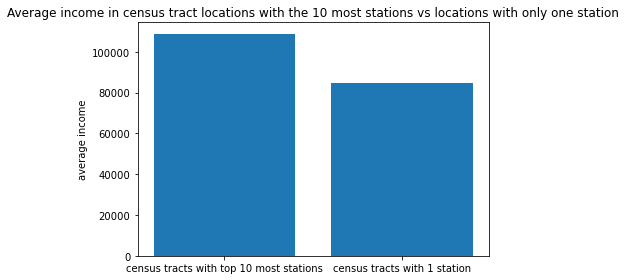

In [13]:
plt.bar(['census tracts with top 10 most stations','census tracts with 1 station'],[mean_income_in_top_10_locations,mean_income_in_locations_w_one_station])
plt.ylabel('average income')
plt.title('Average income in census tract locations with the 10 most stations vs locations with only one station')
plt.tight_layout()
plt.show()

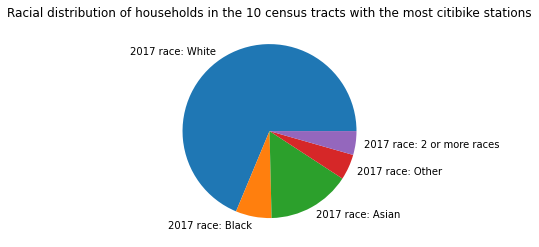

In [14]:
top_10_race_sum = top_10_stations_geoid_race_income_df[['2017 race: White','2017 race: Black','2017 race: Asian','2017 race: Other','2017 race: 2 or more races']].sum()
mylabels = top_10_race_sum.index
plt.pie(top_10_race_sum,labels=mylabels)
plt.title('Racial distribution of households in the 10 census tracts with the most citibike stations')
plt.show()

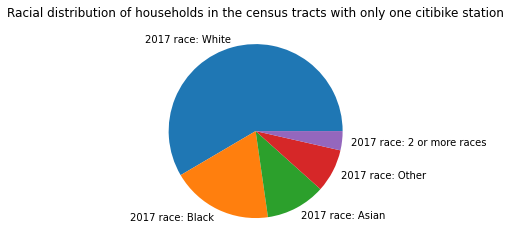

In [15]:
one_station_geoid_race_sum = one_station_geoid_race_income_df[['2017 race: White','2017 race: Black','2017 race: Asian','2017 race: Other','2017 race: 2 or more races']].sum()
mylabels = one_station_geoid_race_sum.index
plt.pie(one_station_geoid_race_sum,labels=mylabels)
plt.title('Racial distribution of households in the census tracts with only one citibike station')
plt.show()

From these results we see that the 10 locations with the most Citibike stations has a higher average income compared to the locations with only one citibike station. We also see that the locations that have a higher number of stations also have a much smaller proportion of Black households as seen by the much smaller Orange segment in the first piechart. Thus, we will explore this relationship between the number of stations in a given area and the race and income distribution of the area further in our project. 

##### Corelation between number of stations in a census tract, income, and race

In [16]:
#produce a data frame with columns geoid, and the number of stations in that geoid
geoid_station_count_df = combined_table.groupby('geoid')[['station_id']].count()
geoid_station_count_df.rename(columns={'station_id':'num_stations_in_census_tract'},inplace=True)
geoid_station_count_df.reset_index(inplace=True)

In [17]:
race_and_income_station_count_df= race_and_income.set_index('geoid').join(geoid_station_count_df.set_index('geoid'),how='inner')
print('Correlation between the number of stations in the census tract with the race and income data in that census tract \n')
race_and_income_station_count_df[['2017 median income','2017 race: total households','2017 race: White',
       '2017 race: Black', '2017 race: Asian', '2017 race: Other',
       '2017 race: 2 or more races', 'num_stations_in_census_tract']].corr()[['num_stations_in_census_tract']]

Correlation between the number of stations in the census tract with the race and income data in that census tract 



,num_stations_in_census_tract
2017 median income,0.170209
2017 race: total households,0.068914
2017 race: White,0.110627
2017 race: Black,-0.128923
2017 race: Asian,0.105689
2017 race: Other,-0.052208
2017 race: 2 or more races,0.080225
num_stations_in_census_tract,1.000000


From these results we see that there is a positive corelation of 0.17 between the number of stations in a census tract and the median income in the census tract. This means that as the number of stations in a given area increases, the median income of the area also seems to increase. Furthermore, there is a negative correlation between the number of black households in a given area and the number of Citibike stations in this area. These two findings relate well to the findings above, as it indicates that the greater the number of Citibike stations in a given area the higher the avaerage income in the area and the lower the number of Black households. 

<br/>

### Citi Bike Trip Data


In [73]:
# read the csv file
df = pd.read_csv('./final_trip_data.csv')

#### 1. General Analysis of Citibike Trip Data

#### Trips by time 

Here we look at citbike bike trips by time of day.

In [24]:
df['start hour']=df['starttime'].dt.hour.astype('category')
df['start day']=df['starttime'].dt.day.astype('category') 
df['weekday']=df['starttime'].dt.weekday.astype('category')

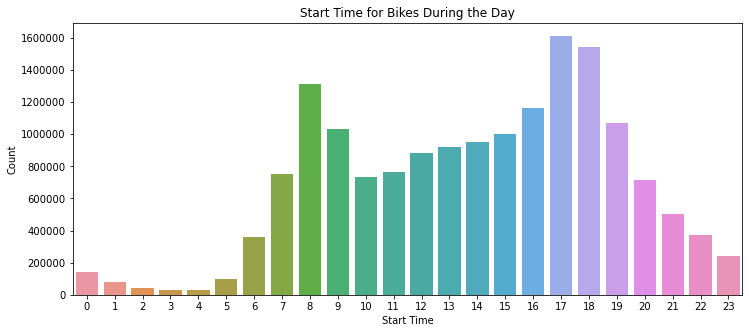

In [71]:
plt.figure(figsize=(12,5))
time= sns.countplot(data=df, x="start hour")
plt.ticklabel_format(style='plain', axis='y')
time.set(xlabel='Start Time', ylabel='Count',title="Start Time for Bikes During the Day")
plt.show()

From this graph we can see that people's start time for riding bikes are mostly at 8-9am, and 4-7pm usual times when people commute to and from work. 

#### Number of Trips Per Month

In [31]:
df['months']=df['starttime'].dt.month.astype('category')

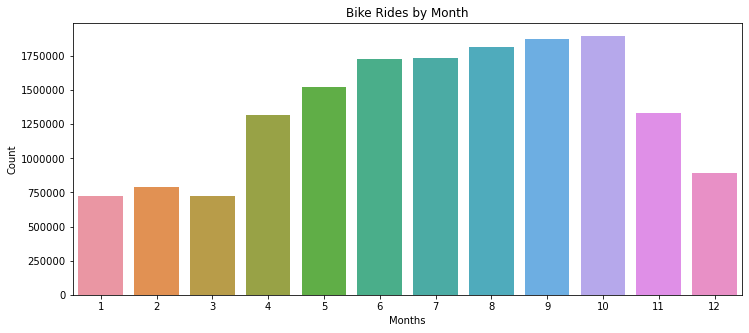

In [42]:
plt.figure(figsize=(12,5))
time= sns.countplot(data=df, x="months");
plt.ticklabel_format(style='plain', axis='y')
time.set(xlabel='Months', ylabel='Count',title="Bike Rides by Month")
plt.show()

From this we can see that in 2017, people ride bikes are mostly at times from April to October when the weather is warm. 

#### Trip Duration Plot

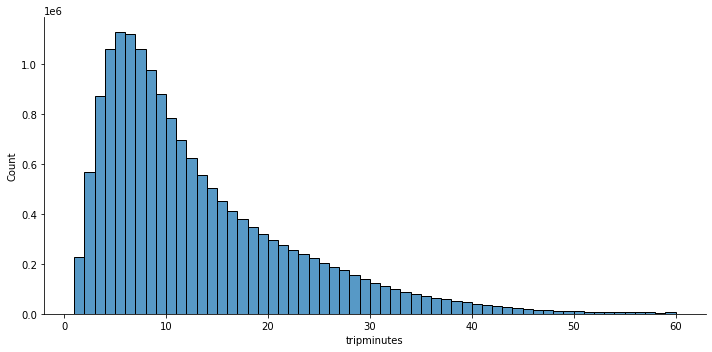

In [8]:
sns.displot(data=df,x="tripminutes", bins=range(1,61), aspect=10/5);

For trip duration by minutes we get a right-skewed graph where most of the trip times don't exceed 20minutes. 
From this we can see that New York City bike-riders don't travel very far distances.

#### Indentifying Popular Trips

In [6]:
#Identify the 10 most popular trips
trips_df = pd.DataFrame()
trips_df = df.groupby(['start station name','end station name']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df['start station name'] = trips_df["start station name"].astype(str)
trips_df["end station name"] = trips_df["end station name"].astype(str)
trips_df["Trip"] = trips_df["start station name"] + " to " + trips_df["end station name"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['start station name', "end station name"], axis = 1)
trips_df = trips_df.reset_index()

/Users/seongheelee/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


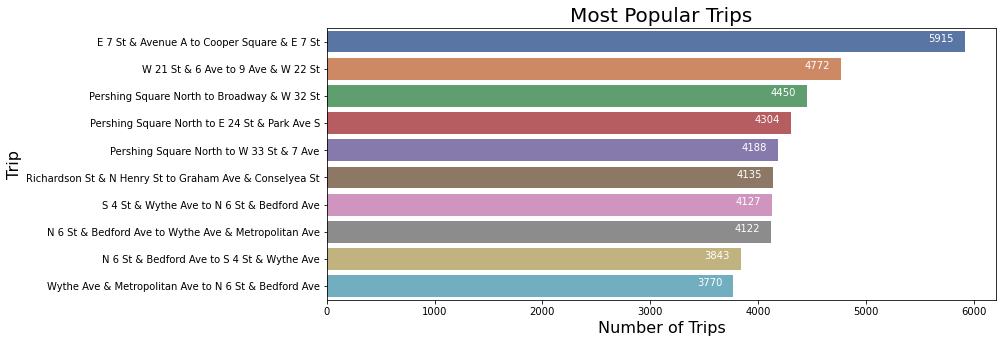

In [9]:
plt.figure(figsize=(12,5))
ax4 = sns.barplot('Number of Trips','Trip', data = trips_df, palette="deep")
ax4.set_title('Most Popular Trips', fontsize = 20)
ax4.set_ylabel("Trip",fontsize=16)
ax4.set_xlabel("Number of Trips",fontsize=16)
for index, row in trips_df.iterrows():
    ax4.text(row['Number of Trips']-220,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

Here we can see what the 10 most popular station to station trips are.
The station routes with the most trips are "E 7St & Avenue A" to "Cooper Square & E7St" are the most popular trips with 5915 trips in total for 2017.


#### Create and save data of count of trips 

In [39]:
count_trips_df = pd.DataFrame()
count_trips_df = df.groupby(['start station name','end station name']).size().reset_index(name = 'Number of Trips')
count_trips_df = count_trips_df.sort_values('Number of Trips', ascending = False)
count_trips_df['start station name'] = count_trips_df["start station name"].astype(str)
count_trips_df["end station name"] = count_trips_df["end station name"].astype(str)

In [40]:
count_trips_df.head()

,start station name,end station name,Number of Trips
137522,E 7 St & Avenue A,Cooper Square & E 7 St,5915
261528,W 21 St & 6 Ave,9 Ave & W 22 St,4772
218418,Pershing Square North,Broadway & W 32 St,4450
218551,Pershing Square North,E 24 St & Park Ave S,4304
218882,Pershing Square North,W 33 St & 7 Ave,4188


In [41]:
count_trips_df.shape

(299340, 3)

In [43]:
#save to csv
count_trips_df = count_trips_df.to_csv('./count_trips.csv')


#### Indentifying Most Unpopular Trips

In [21]:
#Identify the 10 most unpopular trips
trips_df = pd.DataFrame()
trips_df = df.groupby(['start station name','end station name']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = True)
trips_df['start station name'] = trips_df["start station name"].astype(str)
trips_df["end station name"] = trips_df["end station name"].astype(str)
trips_df["Trip"] = trips_df["start station name"] + " to " + trips_df["end station name"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['start station name', "end station name"], axis = 1)
trips_df = trips_df.reset_index()

/Users/seongheelee/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


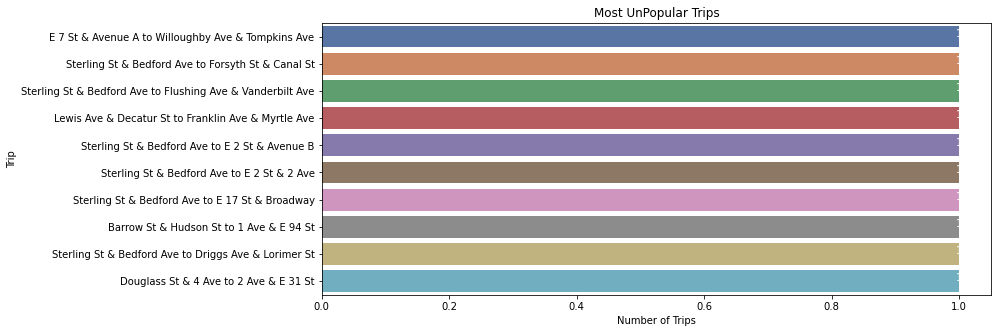

In [34]:
plt.figure(figsize=(12,5))
ax4 = sns.barplot('Number of Trips','Trip', data = trips_df, palette="deep")
ax4.set_title('Most UnPopular Trips')
ax4.set_ylabel("Trip")
ax4.set_xlabel("Number of Trips")
for index, row in trips_df.iterrows():
    ax4.text(row['Number of Trips'],index,row['Number of Trips'], 
             color='white', ha="center")
plt.show()

Here the numbers don't have much significance (since they are all 1), but we can check to see what the geoid of the the ten most unpopular stations are. 

In the next step of our data analysis here, we will look at the ten most popular and unpopular trip geo data.

<br/>

### Exploring Trip Data for Start Station Geoids and End Station Geoids

In [2]:
# read the csv file that contains only the start station geoid and end station geoids
geo_id_df = pd.read_csv('start_end_geoid.csv')

Removing NaN values from df 

In [4]:
geo_id_df.dropna(inplace = True)
geo_id_df.shape

#### Counting the Number of Trips Starting at Each Geoid 

In [5]:
start_counts = geo_id_df['start_station_geoid'].value_counts().rename_axis('start_station').to_frame('trips')
## resetting the index so it's now subscriptable 
start_counts = start_counts.reset_index()

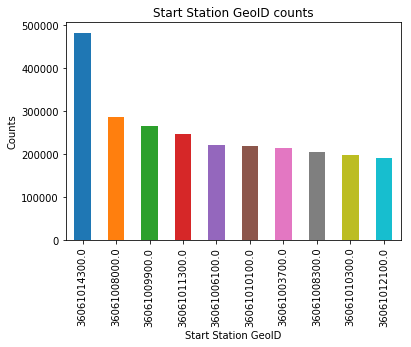

In [218]:
# Due to large size, going to only graph the top ten stations for both start and end 
sliced_start = start_counts.iloc[:10]
sliced_start.plot(x='start_station', y='trips', kind='bar', legend=False)
plt.title('Start Station GeoID counts')
plt.xlabel('Start Station GeoID')
plt.ylabel('Counts')
plt.show()

From this chart, we can see that the geoid, 36061014300, had the most trips starting from a station in that area. This geoid corresponds to the Central park area, which, as found above, is the census tract with the most citibike stations.

### Counting the number of trips that ended at each geo_station_id

In [6]:
end_counts = geo_id_df['end_station_geoid'].value_counts().rename_axis('end_station').to_frame('trips')
#resetting index so now subscriptable
end_counts = end_counts.reset_index()

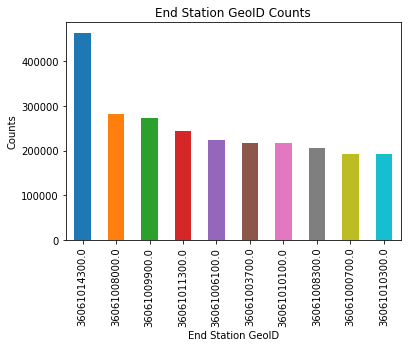

In [217]:
#Due to large size, going to only graph the top ten stations
sliced_end = end_counts.iloc[:10]
sliced_end.plot(x='end_station', y='trips', kind='bar', legend=False)
plt.title('End Station GeoID Counts')
plt.xlabel('End Station GeoID')
plt.ylabel('Counts')
plt.show()

From this chart, we can see that most Citibike trips end at the same geo id that was found to be the highest for start geoid. This is consistent with the popularity of Manhattan and Central park. 

## Plotting most popular start and end station routes

In [7]:
#Using groupby to find the unique counts of each route from start station x to end station y
routes = geo_id_df.groupby(['start_station_geoid', 'end_station_geoid']).count()
#resetting index so that it's subscriptable
routes = routes.reset_index()
#renaming column to counts
routes = routes.rename(columns = {'Unnamed: 0': 'counts'})
routes = routes.drop(columns = ['route_count']) #dropping random added col

### Sorting values by counts column to see the most popular trip routes

In [8]:
# sorting the values by descending count values
routes_for_slice = routes.sort_values(by = ['counts'], ascending = False)
routes_for_slice = routes_for_slice.reset_index()
# show the entire geo_id
pd.set_option('float_format', '{:0}'.format)
#adding a column with start and end geo id as a pair
routes_for_slice['pair'] = list(zip(routes_for_slice['start_station_geoid'],routes_for_slice['end_station_geoid']))

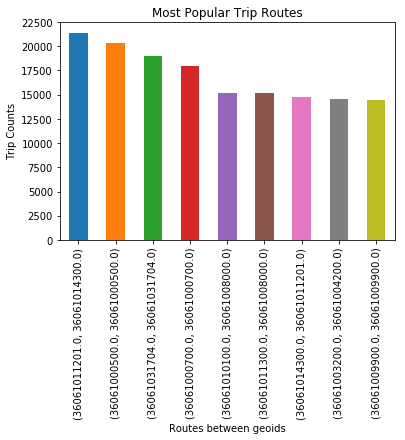

In [220]:
# slicing the top ten routes from the data frame
# Removed first row since it seemed abnormally high and from the same station 
routes_sliced = routes_for_slice.iloc[1:10]
routes_sliced.plot(x = 'pair',y = 'counts', kind = 'bar', legend = False)
plt.ylabel ('Trip Counts')
plt.title('Most Popular Trip Routes')
plt.xlabel('Routes between geoids')
plt.show()

The highest route before removal was from 36061014300 to 36061014300. The number of trips was much higher compared to the next 9 highest routes at almost 200,000. The high usage of Citibikes in this area is even supported by the next highest count route which ends at 36061014300. 

<br/>



### Additional Data Cleaning & Combining:  Connecting Start Station and End Station Geo Ids with Neighborhood

Though we have the geoid, lat&long of our current station data, we wanted to add another measurement of dividing NYC locations. We decided to add neighborhood locations to the trip data since using the census tract from the geoid to divide locations would end up dividing the locations of nyc into smaller regions. We wanted to have a larger region just in case the dividing by smaller census tract would end up being more complicated.
For our next step, we plan on connecting the geoid to its corresponding neighborhood. This is done in order to accurately track which routes stay within each neighborhood. 

##### Citibike Trips by Neighborhood,Borough, and CountyCode

We have linked the citibike stations to unique geoids, we also labeled the geoids for the start stations and end stations.
So we can have an overall idea of wher people are traveling.

With the geoids, we can also know the neighborhoods that the citibike trips are occurring in. 
This notebook will attach the start and end neighborhoods of the trips to the end of the final trip data.


In [5]:
# read csv
trips= pd.read_csv('../../../clean_trip_data.csv')
#read excel file of census tracts to neighborhood
neigh= pd.read_excel('../nyc_census_tracts/nyc2010census_tabulation_equiv.xlsx')

In [7]:
trips.head()

,Unnamed: 0,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes
0,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11
1,1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21
2,6,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10,9
3,7,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10,13
4,8,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10,4


In [7]:
neigh.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,New York City 2010 Census Tract to Neighborhoo...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),NaN
3,NaN,NaN,NaN,NaN,NaN,Code,Name
4,Bronx,005,2,031000,3704,BX31,Allerton-Pelham Gardens


It seems that the neighborhood data  starts at the 2nd. row we will drop the first two rows

In [4]:
neigh=neigh.drop([0, 1])
neigh.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
2,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),NaN
3,NaN,NaN,NaN,NaN,NaN,Code,Name
4,Bronx,005,2,031000,3704,BX31,Allerton-Pelham Gardens
5,Bronx,005,2,031200,3704,BX31,Allerton-Pelham Gardens
6,Bronx,005,2,031400,3704,BX31,Allerton-Pelham Gardens


In [5]:
neigh.columns = neigh.iloc[0]
neigh = neigh[1:]

In [10]:
neigh.head()

2,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),NaN
3,NaN,NaN,NaN,NaN,NaN,Code,Name
4,Bronx,005,2,031000,3704,BX31,Allerton-Pelham Gardens
5,Bronx,005,2,031200,3704,BX31,Allerton-Pelham Gardens
6,Bronx,005,2,031400,3704,BX31,Allerton-Pelham Gardens
7,Bronx,005,2,031600,3704,BX31,Allerton-Pelham Gardens


In [6]:
#reset the index
neigh=neigh.reset_index()
neigh.head()

2,index,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),NaN
0,3,NaN,NaN,NaN,NaN,NaN,Code,Name
1,4,Bronx,005,2,031000,3704,BX31,Allerton-Pelham Gardens
2,5,Bronx,005,2,031200,3704,BX31,Allerton-Pelham Gardens
3,6,Bronx,005,2,031400,3704,BX31,Allerton-Pelham Gardens
4,7,Bronx,005,2,031600,3704,BX31,Allerton-Pelham Gardens


In [7]:
#rename last column
neigh.columns = neigh.columns.fillna('neighborhood')

In [13]:
neigh.head()

2,index,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),neighborhood
0,3,NaN,NaN,NaN,NaN,NaN,Code,Name
1,4,Bronx,005,2,031000,3704,BX31,Allerton-Pelham Gardens
2,5,Bronx,005,2,031200,3704,BX31,Allerton-Pelham Gardens
3,6,Bronx,005,2,031400,3704,BX31,Allerton-Pelham Gardens
4,7,Bronx,005,2,031600,3704,BX31,Allerton-Pelham Gardens


In [15]:
neigh.columns

Index(['index', 'Borough', '2010 Census Bureau FIPS County Code',
       '2010 NYC Borough Code', '2010 Census Tract', 'PUMA',
       'Neighborhood Tabulation Area (NTA)', 'neighborhood'],
      dtype='object', name=2)

In [16]:
trips.head()

,Unnamed: 0,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes
0,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11
1,1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21
2,6,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10,9
3,7,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10,13
4,8,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10,4


In [18]:
trips=trips.drop(columns=['Unnamed: 0'])

In [19]:
trips.columns

Index(['starttime', 'stoptime', 'start station name', 'end station name',
       'usertype', 'birth year', 'gender', 'start_station_geoid',
       'end_station_geoid', 'tripminutes'],
      dtype='object')

**The last 6 digits of the geoid in the trip data can be used to find the neighborhood data. 
The last 6 digits are the 2010 Census Tract Numbers we will use them to match the neighborhood name**

## Add citibike neighborhoods to start and end stations of tripdata

In [20]:
# get last 6 digits of start_station_geoid
trips['n_start_id']=trips['start_station_geoid'].astype(str).str[5:-2]

In [21]:
# get last 6 digits of end_station_geoid
trips['n_stop_id']=trips['end_station_geoid'].astype(str).str[5:-2]

In [22]:
trips.head()

,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes,n_start_id,n_stop_id
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600
2,2017-01-01 00:05:00,2017-01-01 00:14:20,Broadway & W 60 St,9 Ave & W 45 St,Subscriber,1973.0,1,3.606101e+10,3.606101e+10,9,014500,012100
3,2017-01-01 00:05:37,2017-01-01 00:19:24,Broadway & W 37 St,E 10 St & Avenue A,Subscriber,1977.0,2,3.606101e+10,3.606100e+10,13,010900,003200
4,2017-01-01 00:05:47,2017-01-01 00:10:02,York St & Jay St,Carlton Ave & Flushing Ave,Subscriber,1989.0,1,3.604700e+10,3.604702e+10,4,002100,021100


In [23]:
trips.dtypes

starttime               object
stoptime                object
start station name      object
end station name        object
usertype                object
birth year             float64
gender                   int64
start_station_geoid    float64
end_station_geoid      float64
tripminutes              int64
n_start_id              object
n_stop_id               object
dtype: object

In [24]:
neigh.dtypes

2
index                                   int64
Borough                                object
2010 Census Bureau FIPS County Code    object
2010 NYC Borough Code                  object
2010 Census Tract                      object
PUMA                                   object
Neighborhood Tabulation Area (NTA)     object
neighborhood                           object
dtype: object

The two datatypes of the n_start_id and n_stop_id and the 2010 Census Tracts are same datatypes that we can use to compare

In [25]:
# Matching the geoids to the start station ID 
new_data =trips.join(neigh.set_index(['2010 Census Tract']), on=['n_start_id'], how='left').copy()

In [26]:
new_data.head()

,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes,n_start_id,n_stop_id,index,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,PUMA,Neighborhood Tabulation Area (NTA),neighborhood
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,42.0,Bronx,005,2,3705,BX01,Claremont-Bathgate
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,955.0,Brooklyn,047,3,4005,BK37,Park Slope-Gowanus
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,1332.0,Manhattan,061,1,3806,MN12,Upper West Side
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600,237.0,Bronx,005,2,3709,BX09,Soundview-Castle Hill-Clason Point-Harding Park
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600,1180.0,Manhattan,061,1,3809,MN22,East Village


In [27]:
# Changing the column to start station geo ID
new_data.rename(columns = {'neighborhood': 'start_station_neighborhood'}, inplace = True)

In [28]:
neigh.dtypes

2
index                                   int64
Borough                                object
2010 Census Bureau FIPS County Code    object
2010 NYC Borough Code                  object
2010 Census Tract                      object
PUMA                                   object
Neighborhood Tabulation Area (NTA)     object
neighborhood                           object
dtype: object

In [30]:
# Dropping the columns carried over from station ID
new_data = new_data.drop(['index', 'PUMA', 'Neighborhood Tabulation Area (NTA)','2010 NYC Borough Code'], axis = 1)

In [31]:
new_data.head()

,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes,n_start_id,n_stop_id,Borough,2010 Census Bureau FIPS County Code,start_station_neighborhood
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,Bronx,005,Claremont-Bathgate
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,Brooklyn,047,Park Slope-Gowanus
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,Manhattan,061,Upper West Side
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600,Bronx,005,Soundview-Castle Hill-Clason Point-Harding Park
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600,Manhattan,061,East Village


In [32]:
# Rename columns
new_data.rename(columns = {'Borough': 'start_borough','2010 Census Bureau FIPS County Code':'start_county_code'}, inplace = True)

In [33]:
new_data.head()

,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,tripminutes,n_start_id,n_stop_id,start_borough,start_county_code,start_station_neighborhood
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,Bronx,005,Claremont-Bathgate
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,Brooklyn,047,Park Slope-Gowanus
0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,11,016500,014300,Manhattan,061,Upper West Side
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600,Bronx,005,Soundview-Castle Hill-Clason Point-Harding Park
1,2017-01-01 00:00:45,2017-01-01 00:22:08,Cooper Square & E 7 St,Broadway & W 32 St,Subscriber,1987.0,2,3.606100e+10,3.606101e+10,21,004200,007600,Manhattan,061,East Village


#### Save to csv 
The data was getting very big so I'm stopping it midway and saving it to a csv.
After reloading the jupyter notebook I will add the end neighborhoods

In [35]:
start_neigh = new_data.to_csv('./startneigh.csv')

## Adding end station Neighborhoods

Since the data is really large I am adding the endstation data here. After reloading the jupyternotebook

In [2]:
# read csv
new_data= pd.read_csv('../../../startneigh.csv')

In [3]:
#read excel file
neigh= pd.read_excel('../nyc_census_tracts/nyc2010census_tabulation_equiv.xlsx')

In [6]:
neigh.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,New York City 2010 Census Tract to Neighborhoo...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Borough,2010 Census Bureau FIPS County Code,2010 NYC Borough Code,2010 Census Tract,PUMA,Neighborhood Tabulation Area (NTA),NaN
3,NaN,NaN,NaN,NaN,NaN,Code,Name
4,Bronx,005,2,031000,3704,BX31,Allerton-Pelham Gardens


In [8]:
#convert census tract to float
neigh['2010 Census Tract']=neigh['2010 Census Tract'].astype(float)

In [22]:
new_data['n_stop_id'].head()

0    14300.0
1    14300.0
2    14300.0
3     7600.0
4     7600.0
Name: n_stop_id, dtype: float64

In [9]:
# Matching the geoids to the start station ID 
new_data =new_data.join(neigh.set_index(['2010 Census Tract']), on=['n_stop_id'], how='left')

In [11]:
new_data = new_data.drop(['index', 'PUMA', 'Neighborhood Tabulation Area (NTA)','Borough'], axis = 1)

In [10]:
new_data.rename(columns = {'neighborhood': 'end_station_neighborhood','2010 Census Bureau FIPS County Code':'end_county_code','2010 NYC Borough Code':'end_borough_code'}, inplace = True)

In [11]:
new_data.head()

,Unnamed: 0,starttime,stoptime,start station name,end station name,usertype,birth year,gender,start_station_geoid,end_station_geoid,...,start_borough,start_county_code,start_station_neighborhood,index,Borough,end_county_code,end_borough_code,PUMA,Neighborhood Tabulation Area (NTA),end_station_neighborhood
0,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,...,Bronx,5.0,Claremont-Bathgate,58,Bronx,005,2,3708,BX14,East Concourse-Concourse Village
0,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,...,Bronx,5.0,Claremont-Bathgate,948,Brooklyn,047,3,4005,BK37,Park Slope-Gowanus
0,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,...,Bronx,5.0,Claremont-Bathgate,1288,Manhattan,061,1,3806,MN99,park-cemetery-etc-Manhattan
0,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,...,Bronx,5.0,Claremont-Bathgate,1406,Queens,081,4,4101,QN70,Astoria
1,0,2017-01-01 00:00:21,2017-01-01 00:11:41,W 82 St & Central Park West,Central Park West & W 72 St,Subscriber,1965.0,2,3.606102e+10,3.606101e+10,...,Brooklyn,47.0,Park Slope-Gowanus,58,Bronx,005,2,3708,BX14,East Concourse-Concourse Village


In [12]:
#save data
trip_neigh = new_data.to_csv('./tripneigh.csv')


<br/>

_______________

<br/>


# Questions for Reviewers

- 

_______________

## Brief Plan of Next Steps 

- Look into creating a geomap plot for the station locations and race & income distribution with the number of trips